In [34]:
from sklearn.datasets._samples_generator import make_blobs
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import random
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, silhouette_score

inizialmente creo una funzione per generare in maniera randomica un dataset clusterizzato con un numero di cluster tra 50 e 200 contenente tra 4000 e 8000 esempi con una deviazione standard che può andare tra 0.3 e 0.8 tramite make_blobs in modo che il dataset sia replicabile

In [35]:
def generateRandomBlob(i):
  random.seed(i)
  n_cluster = random.randint(50, 200)
  n_samples = random.randint(4000, 8000)
  cluster_std = random.uniform(0.3, 0.8)
  return make_blobs(n_samples=n_samples, centers=n_cluster, cluster_std=cluster_std, random_state=42)

nella funzione sottostante do la possibilità di mostrare il threshold

In [36]:
def showThreshold(threshold, link_matrix):
  plt.figure(figsize=(12,6))
  dendrogram(link_matrix)
  plt.xticks(fontsize=10, rotation=90)
  plt.axhline(y=threshold, color='red', linestyle='--', label=f'Soglia = {threshold}')
  plt.tight_layout()
  plt.show()

Questa funzione permetterà di calcolare gli iperparametri in modo automatico basandosi sulla siluette della link matrix e dei punti

In [37]:
def adaptiveThresholdParams(link_matrix, X):
    from scipy.spatial.distance import pdist
    
    n_samples = X.shape[0]
    avg_dist = np.mean(pdist(X))
    merge_gaps = link_matrix[-10:, 2]
    gap_ratio = merge_gaps[-1] / (merge_gaps[-2] + 1e-8)

    # Adatta i parametri
    sample_frac = 0.1 if n_samples > 10000 else 0.3
    step = 10 if n_samples > 10000 else 2
    max_t = 80 if gap_ratio > 1.5 else 40

    return [step, max_t, sample_frac]

in questa funzione trovo il threshold vero e proprio

In [38]:
#max_t=50, step=5, sample_frac=0.2
def findBestThresholdWithClustersFast(link_matrix, X, max_t="auto", step="auto", sample_frac="auto", random_state=42, verbose=False):
   if(max_t == 'auto' or step=='auto' or sample_frac == 'auto'):
    step, max_t, sample_frac = adaptiveThresholdParams(link_matrix, X)
    if (verbose):
        print(f'max_t: {max_t}, step: {step}, sample_frac: {sample_frac}')
    rng = np.random.default_rng(random_state)
    n_samples = int(len(X) * sample_frac)
    idx_sample = rng.choice(len(X), n_samples, replace=False)
    X_sample = X[idx_sample]
    
    best_score = -1
    best_t = -1
    best_n_cluster = 0
    
    for t in range(1, max_t, step):
        clusters = fcluster(link_matrix, t=t, criterion='distance')
        clusters_sample = clusters[idx_sample]
        n_clusters = len(set(clusters_sample))
        if n_clusters < 2:
            continue
        
        score = silhouette_score(X_sample, clusters_sample)
        if score > best_score:
            best_score = score
            best_t = t
            best_n_cluster = n_clusters
    
    return best_t, best_n_cluster, best_score

In questa funzione stimo i centroidi

In [39]:
def estimate_centroids(data, linked, threshold):
  if isinstance(data, np.ndarray):
      data = pd.DataFrame(data, columns=[f"x{i+1}" for i in range(data.shape[1])])
  
  cluster_labels = fcluster(linked, t=threshold, criterion='distance')
  data['cluster'] = cluster_labels

  centroidi = data.groupby('cluster').mean(numeric_only=True)

  return centroidi

in questa calcolo gli score di omogeneità, completezza e v_mesure

In [40]:
def scores (true_labels, predicted_labels):
  hom = homogeneity_score(true_labels, predicted_labels)
  comp = completeness_score(true_labels, predicted_labels)
  v = v_measure_score(true_labels, predicted_labels)
  return [hom, comp, v]

genero un random blob con seme a 12

In [41]:
X, true_lables = generateRandomBlob(12)

creo la matrice di linkage

In [42]:
link_matrix = linkage(X, method="ward")

trovo il threshold, il numero di cluster e il miglior punteggio di sulhette, utilizzando iperparametri calcolati automaticamente

In [43]:
# threshold, value = findThreshold(link_matrix )
threshold, value, best_score  = findBestThresholdWithClustersFast(link_matrix=link_matrix, X=X, verbose=True)

max_t: 40, step: 2, sample_frac: 0.3


In [44]:
threshold, value, best_score

(35, 23, np.float64(0.36742371211299824))

In [45]:
dfy = pd.DataFrame(true_lables)
real_size = dfy[0].unique().shape[0]

real_size

171

In questo esempio abbiamo 171 clusters, ma il mio algoritmo ne trova solo 26, apparentemente può sembrare sbagliato, ma andiamo avanti, calcoliamo i centroidi e verifichiamo graficamente se l'occhio umano avrebbe potuto far meglio

In [46]:
centroids = estimate_centroids(X, link_matrix, threshold=threshold)


Visualizziamo la cluterizzazione proposta dall'algoritmo e calcoliamone i parametri

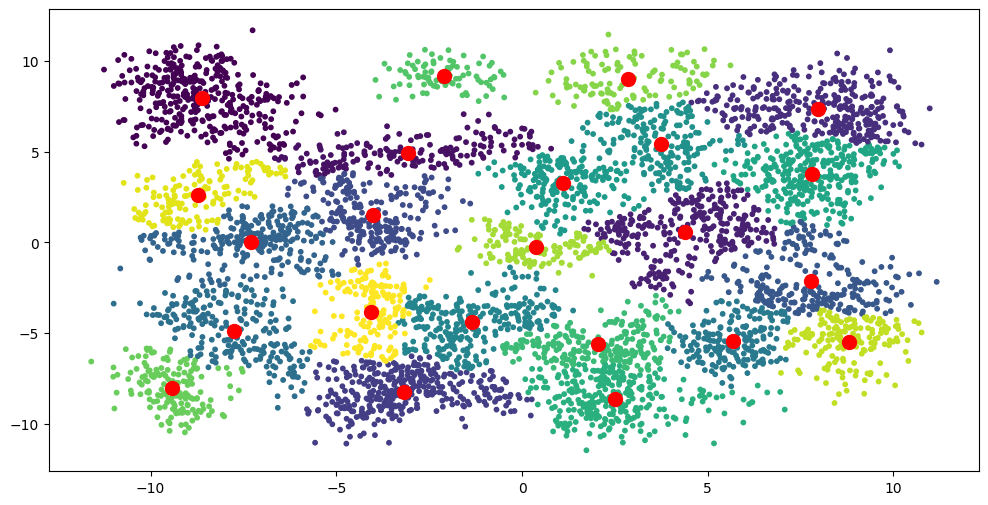

hom: 0.5400791862217343, comp: 0.9024025571267404, v: 0.6757365782198098


In [47]:
hc = AgglomerativeClustering(value)
y = hc.fit_predict(X)
plt.figure(figsize=(12,6))
plt.scatter(X[:,0], X[:,1], c=y, s=10, cmap="viridis")
plt.scatter(centroids.iloc[:, 0], centroids.iloc[:, 1], c='red', marker='o', s=100, label='Centroidi stimati')
plt.show()

hom, comp, v = scores(true_labels=true_lables, predicted_labels=y)

print(f'hom: {hom}, comp: {comp}, v: {v}')

Vediamo il caso reale

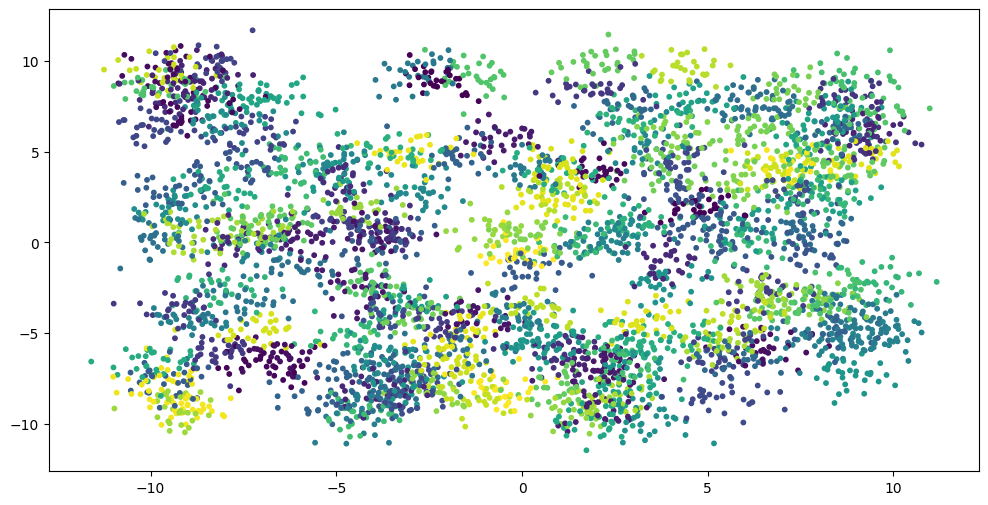

hom: 0.5400791862217343, comp: 0.9024025571267404, v: 0.6757365782198098


In [48]:
# true_lables


hc = AgglomerativeClustering(real_size)
y = hc.fit_predict(X)
plt.figure(figsize=(12,6))
plt.scatter(X[:,0], X[:,1], c=true_lables, s=10, cmap="viridis")
#plt.scatter(centroids.iloc[:, 0], centroids.iloc[:, 1], c='red', marker='o', s=100, label='Centroidi stimati')
plt.show()

print(f'hom: {hom}, comp: {comp}, v: {v}')

Direi che l'occhio umano non avrebbe potuto fare meglio dell'algoritmo in questo caso

ora automatizziamo la generazione di esempi, rendendo ogni esempio replicabile tramite il random_seed, ma allo stesso tempo cercando di creare esempi complessi e non prevedibili

In [49]:
def createExample(random_seed, verbose=False):
  X, true_lables = generateRandomBlob(random_seed)
  
  link_matrix = linkage(X, method="ward")
  #step=2
  threshold, value, _ = findBestThresholdWithClustersFast(link_matrix, X)
  
  centroids = estimate_centroids(X, link_matrix, threshold=threshold)

  hc = AgglomerativeClustering(value)
  y = hc.fit_predict(X)
  
  hom, comp, v = scores(true_labels=true_lables, predicted_labels=y)
  if verbose:
    print(f'hom: {hom}, comp: {comp}, v: {v}')
    
    print('clusterizzazione calcolata')
    plt.figure(figsize=(12,6))
    plt.scatter(X[:,0], X[:,1], c=y, s=10, cmap="viridis")
    plt.scatter(centroids.iloc[:, 0], centroids.iloc[:, 1], c='red', marker='o', s=100, label='Centroidi stimati')
    plt.show()
    
    print('clusterizzazione reale')
    plt.figure(figsize=(12,6))
    plt.scatter(X[:,0], X[:,1], c=true_lables, s=10, cmap="viridis")
    plt.show()
  return [random_seed, hom, comp, v, threshold, value]

proviamo gli esempi per vari semi tra 1 e 20

In [50]:
results_df = pd.DataFrame(columns=["run", "hom", "comp", "v", "threshold", "n_clusters"])
for random_seed in range(1,21):
  results_df.loc[len(results_df)] = createExample(random_seed)

visualizziamo i risultati

In [51]:
results_df

,run,hom,comp,v,threshold,n_clusters
0,1.0,0.626804,0.906467,0.741130,37.0,23.0
1,2.0,0.854304,0.973128,0.909853,11.0,43.0
2,3.0,0.614133,0.941193,0.743275,37.0,23.0
3,4.0,0.771625,0.979504,0.863225,15.0,45.0
4,5.0,0.627082,0.955405,0.757184,39.0,24.0
5,6.0,0.667713,0.974402,0.792418,25.0,39.0
6,7.0,0.730867,0.972353,0.834491,21.0,42.0
7,8.0,0.554918,0.886417,0.682546,39.0,20.0
8,9.0,0.587808,0.944978,0.724779,37.0,26.0
9,10.0,0.613930,0.912748,0.734095,21.0,37.0


i valori medi su omogeneità, completezza e v_measure sembrano accettabili per casi complessi
hom     0.636166
comp    0.930699
v       0.753982

In [52]:
results_df[['hom', 'comp', 'v']].mean()

hom     0.636166
comp    0.930699
v       0.753982
dtype: float64

recuperiamo il caso peggiore per ogni parametro

In [53]:
results_df.loc[results_df['hom'].idxmin()]

run           17.000000
hom            0.534153
comp           0.886370
v              0.666595
threshold     35.000000
n_clusters    25.000000
Name: 16, dtype: float64

In [54]:
results_df.loc[results_df['comp'].idxmin()]

run           17.000000
hom            0.534153
comp           0.886370
v              0.666595
threshold     35.000000
n_clusters    25.000000
Name: 16, dtype: float64

In [55]:
results_df.loc[results_df['v'].idxmin()]

run           17.000000
hom            0.534153
comp           0.886370
v              0.666595
threshold     35.000000
n_clusters    25.000000
Name: 16, dtype: float64

sembra essere quello con seme = 17, ricostruiamolo in modalità verbosa e vediamone la complessità. (la prima immagine è la clusterizzazione calcolata dall'algoritmo, la seconda è la clusterizzazione reale)

hom: 0.5341525823442262, comp: 0.8863698567470168, v: 0.6665952397012292
clusterizzazione calcolata


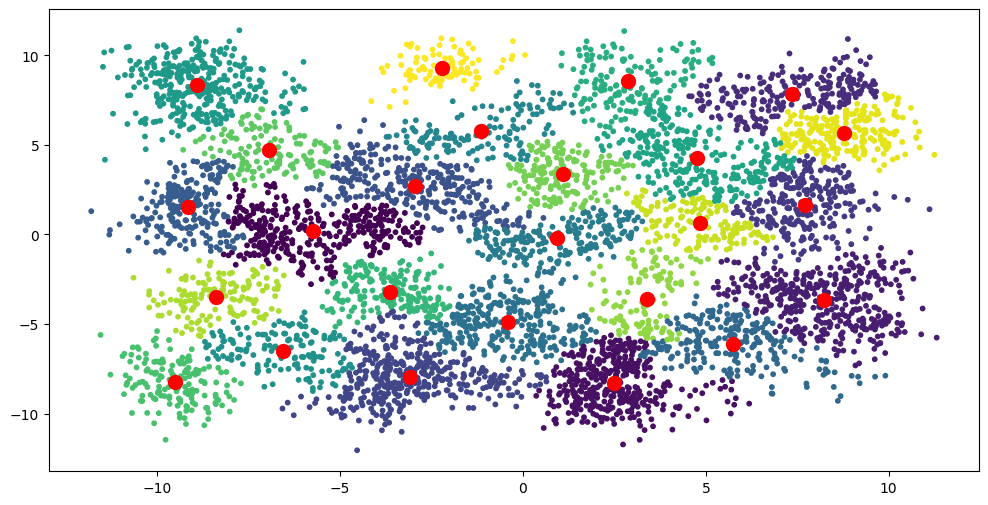

clusterizzazione reale


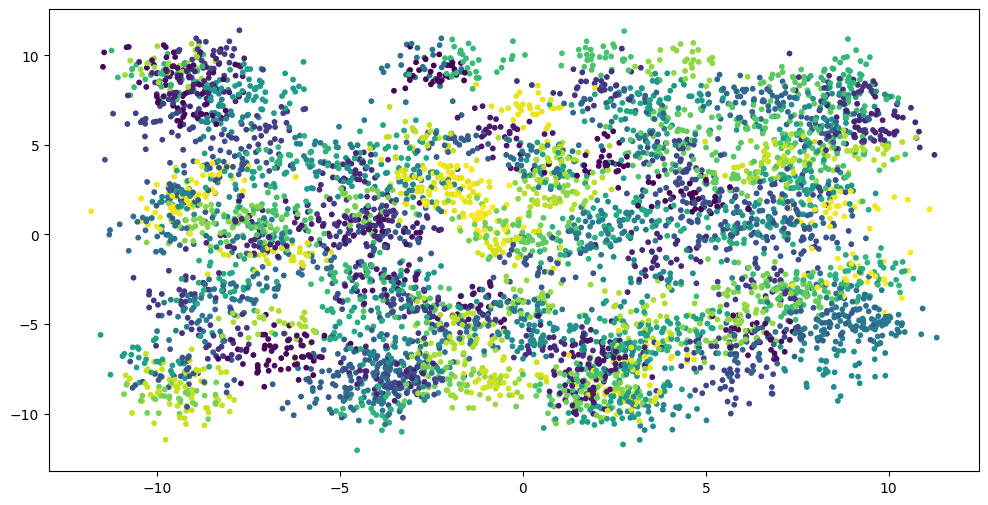

[17,
 np.float64(0.5341525823442262),
 np.float64(0.8863698567470168),
 np.float64(0.6665952397012292),
 35,
 25]

In [56]:
createExample(17, verbose=True)

direi che individuare questa clusterizzazione era un compito estremamente complesso e difficilmente l'occhio umano avrebbe potuto far di meglio.
Mi ritengo soddisfatto del risultato